In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) New Shapes (single-peak, no plateau, no multi-peaks)
#    All templates peak at t0 is 1, then scaled by amp.
# ============================================================

def tpl_gaussian(t: np.ndarray, t0: float, sigma: float) -> np.ndarray:
    z = (t - t0) / float(sigma)
    return np.exp(-0.5 * z * z).astype(np.float32)

def tpl_super_gaussian(t: np.ndarray, t0: float, s: float = 3.8, p: float = 4.0) -> np.ndarray:
    """
    Wide single-peak event, no plateau:
      exp( - (|t-t0|/s)^p ), p>2 makes peak "fatter" but still single-peak.
    Peak at t0 is 1.
    """
    z = np.abs((t - t0) / float(s)).astype(np.float32)
    return np.exp(-(z ** float(p))).astype(np.float32)

def tpl_skewed_gaussian(t: np.ndarray, t0: float, sigma_left: float = 1.8, sigma_right: float = 4.5) -> np.ndarray:
    """
    Single-peak but asymmetric width:
      left uses sigma_left, right uses sigma_right.
    Peak at t0 is 1.
    """
    t = t.astype(np.float32)
    out = np.zeros_like(t, dtype=np.float32)
    left = t <= float(t0)
    right = ~left

    zl = (t[left] - float(t0)) / float(sigma_left)
    zr = (t[right] - float(t0)) / float(sigma_right)
    out[left] = np.exp(-0.5 * zl * zl).astype(np.float32)
    out[right] = np.exp(-0.5 * zr * zr).astype(np.float32)
    return out

def tpl_jittered_peak(
    t: np.ndarray,
    t0: float,
    sigma_env: float = 2.6,
    eps_jitter: float = 0.10,
    f0: float = 0.20,
    center_keep: float = 0.6,
) -> np.ndarray:
    env = tpl_gaussian(t, t0, sigma=float(sigma_env))  # peak=1 at t0

    ph = 2.0 * np.pi * float(f0) * (t - float(t0))
    osc = np.cos(ph).astype(np.float32)                # [-1,1]
    jitter = (1.0 + float(eps_jitter) * osc).astype(np.float32)

    z = np.abs((t - float(t0)) / float(sigma_env)).astype(np.float32)
    gate = (float(center_keep) + (1.0 - float(center_keep)) * (1.0 - np.exp(-z*z))).astype(np.float32)

    out = (env * jitter * gate).astype(np.float32)
    out = (out / (float(np.max(out)) + 1e-12)).astype(np.float32)  # normalize peak=1
    return out

# ============================================================
# 2) Baseline (unchanged)
# ============================================================

def gen_baseline(
    rng: np.random.Generator,
    L: int,
    ks=(5, 8, 11),
    a_rng=(0.02, 0.05),
    b_rng=(-0.03, 0.03),
    A_rng=(0.05, 0.1),
    phis=(0.0, np.pi/2, np.pi, 3*np.pi/2),
    noise=0.01,
    max_abs=0.2
) -> np.ndarray:
    t = np.arange(L, dtype=np.float32)
    tn = (t / (L - 1)).astype(np.float32)

    a = rng.uniform(*a_rng)
    b = rng.uniform(*b_rng)
    trend = (b + a * tn).astype(np.float32)

    season = np.zeros(L, dtype=np.float32)
    for k in ks:
        Ak = rng.uniform(*A_rng)
        phi = float(rng.choice(np.asarray(phis, dtype=np.float32)))
        season += (Ak * np.sin(2 * np.pi * float(k) * t / float(L) + phi)).astype(np.float32)

    x0 = trend + season + rng.normal(0, noise, size=L).astype(np.float32)

    # enforce max|baseline| <= max_abs
    m = float(np.max(np.abs(x0)) + 1e-12)
    if m > float(max_abs):
        x0 = (x0 * (float(max_abs) / m)).astype(np.float32)
    return x0

# ============================================================
# 3) Generator: K~Binomial, loc~GMM, A~Lognormal with floor
#    Shape mixture updated to new event family
# ============================================================

def gen_dataset(
    N=10000, L=200,
    seed=0, seed_evt=1,

    # K ~ Binomial
    K_n=6, K_p=0.5,

    # Location ~ Gaussian Mixture
    loc_mus=(35.0, 115.0, 185.0),
    loc_sigmas=(8.0, 10.0, 8.0),
    loc_w=(0.2, 0.6, 0.2),
    min_gap=25,
    max_tries=200,

    # Amplitude ~ LogNormal, plus floor and clip
    A_mean=1.6,
    A_ln_sigma=0.25,
    A_floor=1.30,
    A_clip=(1.30, 6.0),

    # Shape mixture (new)
    p_shape=(0.6, 0.2, 0.2),    # 0=narrow Gaussian, 1=wide super-Gaussian, 2=skewed Gaussian

    # Shape params (new)
    narrow_sigma=2.2,
    jitter_sigma_env=2.6,
    jitter_eps=0.10,
    jitter_f0=0.20,
    jitter_center_keep=0.6,
    skew_sigma_left=1.8,
    skew_sigma_right=4.5,

    # baseline params
    ks=(5, 8, 11),
    baseline_max_abs=0.2,
    noise=0.01,
):
    rng = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed_evt)

    L = int(L)
    t = np.arange(L, dtype=np.float32)

    # normalize probs
    loc_mus = np.asarray(loc_mus, dtype=np.float32)
    loc_sigmas = np.asarray(loc_sigmas, dtype=np.float32)
    loc_w = np.asarray(loc_w, dtype=np.float32)
    loc_w = loc_w / (loc_w.sum() + 1e-12)
    C = int(loc_mus.size)

    p_shape = np.asarray(p_shape, dtype=np.float32)
    p_shape = p_shape / (p_shape.sum() + 1e-12)

    # lognormal mu to hit mean approximately: mean = exp(mu + 0.5*s^2)
    A_ln_sigma = float(A_ln_sigma)
    A_ln_mu = float(np.log(float(A_mean)) - 0.5 * (A_ln_sigma ** 2))
    A_min, A_max = float(A_clip[0]), float(A_clip[1])

    # baseline
    X0 = np.zeros((N, L), dtype=np.float32)
    for i in range(N):
        X0[i] = gen_baseline(
            rng, L,
            ks=ks,
            noise=float(noise),
            max_abs=float(baseline_max_abs),
        )

    # events
    K = rng2.binomial(n=int(K_n), p=float(K_p), size=N).astype(np.int32)
    X = X0.copy()

    # store true events
    t0_pad = -np.ones((N, int(K_n)), dtype=np.int32)
    A_pad  = np.zeros((N, int(K_n)), dtype=np.float32)
    S_pad  = -np.ones((N, int(K_n)), dtype=np.int32)

    for i in range(N):
        ki = int(K[i])
        if ki == 0:
            continue

        chosen = []
        for e in range(ki):
            sid = int(rng2.choice(3, p=p_shape))

            amp = float(rng2.lognormal(mean=A_ln_mu, sigma=A_ln_sigma))
            amp = max(amp, float(A_floor))
            amp = float(np.clip(amp, A_min, A_max))

            # sample location with reject for min_gap
            t0_int = None
            for _ in range(int(max_tries)):
                c = int(rng2.choice(C, p=loc_w))
                t0_star = float(rng2.normal(loc=float(loc_mus[c]), scale=float(loc_sigmas[c])))
                cand = int(np.round(np.clip(t0_star, 0, L - 1)))
                if all(abs(cand - tt) >= int(min_gap) for tt in chosen):
                    t0_int = cand
                    chosen.append(t0_int)
                    break
            if t0_int is None:
                t0_int = cand
                chosen.append(t0_int)

            # template (new)
            if sid == 0:
                tpl = tpl_gaussian(t, float(t0_int), sigma=float(narrow_sigma))
            elif sid == 1:
                tpl = tpl_jittered_peak(
                    t, float(t0_int),
                    sigma_env=float(jitter_sigma_env),
                    eps_jitter=float(jitter_eps),
                    f0=float(jitter_f0),
                    center_keep=float(jitter_center_keep),
                )
            else:
                tpl = tpl_skewed_gaussian(
                    t, float(t0_int),
                    sigma_left=float(skew_sigma_left),
                    sigma_right=float(skew_sigma_right),
                )
            X[i] += (amp * tpl).astype(np.float32)

            t0_pad[i, e] = int(t0_int)
            A_pad[i, e] = float(amp)
            S_pad[i, e] = int(sid)

    X = X[:, :, None].astype(np.float32)
    X0 = X0[:, :, None].astype(np.float32)

    comps = {
        "X0": X0,
        "K": K,
        "t0": t0_pad,
        "A": A_pad,
        "S": S_pad,
        "shape_names": {0: "smooth_gaussian", 1: "jittered_peak", 2: "skewed_gaussian"},
        "p_shape": p_shape.copy(),
        "loc_mus": loc_mus.copy(),
        "loc_sigmas": loc_sigmas.copy(),
        "loc_w": loc_w.copy(),
        "min_gap": int(min_gap),
        "thr_recommended": 1.0,
        "baseline_max_abs": float(baseline_max_abs),
        "A_floor": float(A_floor),
    }
    return X, comps

# ============================================================
# 4) One-threshold extractor (keep your peak->run pipeline)
#    Classifier updated for new event family
# ============================================================

def _local_maxima_above_thr(x1d: np.ndarray, thr: float) -> np.ndarray:
    x = x1d.astype(np.float32)
    L = x.size
    if L < 3:
        return np.array([], dtype=np.int32)
    mid = x[1:-1]
    left = x[:-2]
    right = x[2:]
    mask = (mid > float(thr)) & (mid > left) & (mid >= right)
    idx = np.flatnonzero(mask) + 1
    return idx.astype(np.int32)

def _nms_peaks(peaks: np.ndarray, x: np.ndarray, min_gap: int) -> np.ndarray:
    if peaks.size == 0:
        return peaks
    order = np.argsort(-x[peaks])  # desc by height
    chosen = []
    for j in order:
        t0 = int(peaks[j])
        if all(abs(t0 - int(tt)) >= int(min_gap) for tt in chosen):
            chosen.append(t0)
    chosen.sort()
    return np.asarray(chosen, dtype=np.int32)

def _extract_run_bounds(x: np.ndarray, t0: int, thr: float) -> tuple[int, int]:
    L = x.size
    l = t0
    while l - 1 >= 0 and x[l - 1] > float(thr):
        l -= 1
    r = t0
    while r + 1 < L and x[r + 1] > float(thr):
        r += 1
    return int(l), int(r)

def _roughness_score(seg: np.ndarray) -> float:
    seg = seg.astype(np.float32)
    if seg.size < 5:
        return 0.0
    peak = float(np.max(seg) + 1e-12)
    y = (seg / peak).astype(np.float32)
    d2 = y[2:] - 2.0*y[1:-1] + y[:-2]
    return float(np.mean(np.abs(d2)))

def _classify_shape_jitter(
    x: np.ndarray,
    l: int,
    r: int,
    jitter_thr: float = 0.06,
    skew_log_thr: float = 0.55,
) -> int:
    seg = x[l:r+1]
    if seg.size == 0:
        return 0

    # 1) skew first
    j = int(np.argmax(seg))
    t_peak = l + j
    left_len = max(0, t_peak - l)
    right_len = max(0, r - t_peak)
    skew_ratio = (right_len + 1.0) / (left_len + 1.0)
    skew_score = abs(float(np.log(skew_ratio)))
    if skew_score >= float(skew_log_thr):
        return 2

    # 2) jitter second
    rs = _roughness_score(seg.astype(np.float32))
    if rs >= float(jitter_thr):
        return 1

    return 0

def extract_events_stats(
    X: np.ndarray,
    thr: float = 1.0,
    min_gap: int = 15,
    class_width_thr: int = 11,
    class_skew_log_thr: float = 0.6
):
    """
    Output events[i] list of dicts:
      {
        "t0": int,           seed peak index
        "amp_raw": float,    raw peak at seed t0
        "shape": int,        0/1/2 using new classifier
        "l","r": int         threshold run bounds
      }
    """
    X = np.asarray(X, dtype=np.float32)
    x = X[:, :, 0] if X.ndim == 3 else X
    N, L = x.shape

    out = []
    for i in range(N):
        xi = x[i]
        peaks = _local_maxima_above_thr(xi, thr=thr)
        peaks = _nms_peaks(peaks, xi, min_gap=int(min_gap))

        ev_i = []
        for t0 in peaks:
            t0 = int(t0)
            l, r = _extract_run_bounds(xi, t0, thr=thr)
            shape = _classify_shape_jitter(
                xi, l, r,
                jitter_thr=0.155,
                skew_log_thr=0.45,
            )
            ev_i.append({
                "t0": t0,
                "amp_raw": float(xi[t0]),
                "shape": int(shape),
                "l": int(l),
                "r": int(r),
            })
        out.append(ev_i)

    return out

def summarize_events(events, n_shapes: int = 3):
    K_per_sample = np.array([len(ei) for ei in events], dtype=np.int32)
    t0s, amps, shapes = [], [], []
    for ei in events:
        for e in ei:
            t0s.append(int(e["t0"]))
            amps.append(float(e["amp_raw"]))
            shapes.append(int(e["shape"]))
    if len(t0s) == 0:
        return K_per_sample, np.array([], np.int32), np.array([], np.float32), np.zeros(n_shapes, np.int64)
    t0s = np.asarray(t0s, dtype=np.int32)
    amps = np.asarray(amps, dtype=np.float32)
    shapes = np.asarray(shapes, dtype=np.int32)
    shape_counts = np.bincount(shapes, minlength=n_shapes).astype(np.int64)
    return K_per_sample, t0s, amps, shape_counts

In [2]:
X, comps = gen_dataset(
    N=10000, L=200,
    loc_mus= (50,100,150),
    p_shape=(0.6, 0.2, 0.2),
    baseline_max_abs=0.2,
    A_floor=1.30,
    min_gap=25,
)

events = extract_events_stats(X, thr=1.0, min_gap=15)

In [3]:
def plot_random_5(X, seed=0):
    X = np.asarray(X)
    X2 = X[:, :, 0] if X.ndim == 3 else X  # (N,L)
    N, L = X2.shape

    rng = np.random.default_rng(seed)
    idx = rng.choice(N, size=min(5, N), replace=False)

    t = np.arange(L)
    plt.figure(figsize=(10, 4))
    for i in idx:
        plt.plot(t, X2[i], alpha=0.9, label=f"idx={int(i)}")
    plt.title("Random 5 samples from X")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


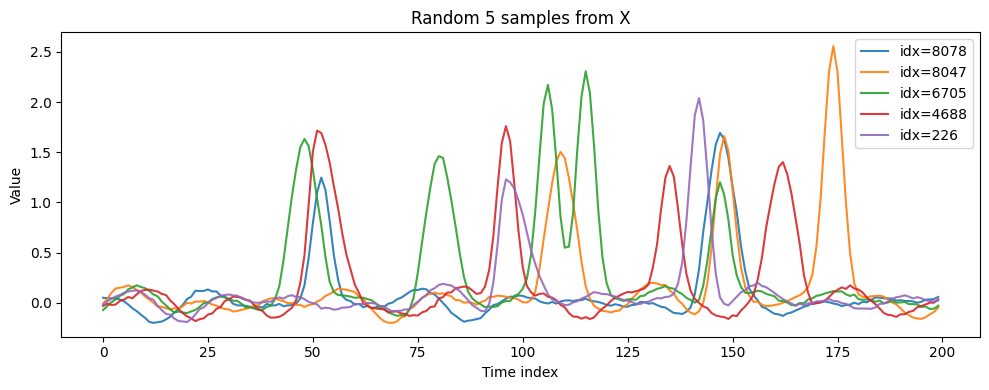

In [4]:
plot_random_5(X,seed=5)

In [5]:
import numpy as np

def eval_detection_discovery_accuracy(
    X,
    comps,
    events_pred,
    w_match=12,
    L=None,
    return_per_event=False
):
    """
    事件“发现”准确性评估（relaxed / discovery-style）。

    定义：
      - 对每个 GT 事件中心 t0_g，窗口 W=[t0_g-w_match, t0_g+w_match]
      - 若存在任一预测事件段 [l_pred, r_pred] 与 W 相交，则认为该 GT 事件被发现 (TP_gt)
      - 若某预测事件段不与任何 GT 窗口相交，则认为是 FP_pred

    指标：
      - recall_discovery = TP_gt / GT_total
      - precision_discovery = (Pred_total - FP_pred) / Pred_total
      - F1_discovery
      - K_exact：每条样本预测事件数 == GT 事件数
      - K_MAE：|K_hat-K_true| 的平均绝对误差

    幅度（你要求的方式）：
      - 对每个被发现的 GT 事件，在其窗口 W 上取 pred_max = max(X[W])
      - 这个 pred_max 是“事件最大值”的代理，用于后续幅度分布/误差分析

    return_per_event=True 时返回每个 GT 事件的 pred_max、found 标记等，便于做更细统计。
    """
    X = np.asarray(X, dtype=np.float32)
    x = X[:, :, 0] if X.ndim == 3 else X
    N, Lx = x.shape
    if L is None:
        L = Lx
    else:
        L = int(L)

    # sanity
    assert int(comps["K"].shape[0]) == N, "X and comps size mismatch"
    assert len(events_pred) == N, "events_pred length mismatch"

    GT_total = 0
    Pred_total = 0

    TP_gt = 0   # number of GT events that are found
    FP_pred = 0 # number of predicted events not explained by any GT window

    K_true = comps["K"].astype(np.int32)
    K_hat = np.array([len(ei) for ei in events_pred], dtype=np.int32)

    K_exact = int(np.sum(K_true == K_hat))
    K_mae = float(np.mean(np.abs(K_true - K_hat)))

    # optional per-event outputs
    per_event = []  # list of dicts: {i, t0g, found, pred_max, gt_A, gt_shape}

    for i in range(N):
        ki = int(K_true[i])
        GT_total += ki

        # GT windows
        gt_t0 = comps["t0"][i, :ki].astype(np.int32)
        gt_A  = comps["A"][i,  :ki].astype(np.float32)
        gt_S  = comps["S"][i,  :ki].astype(np.int32)

        gt_windows = []
        for t0g in gt_t0:
            a = max(0, int(t0g) - int(w_match))
            b = min(L - 1, int(t0g) + int(w_match))
            gt_windows.append((a, b))

        # Pred intervals
        pred_list = events_pred[i]
        Pred_total += len(pred_list)
        pred_intervals = [(int(e["l"]), int(e["r"])) for e in pred_list]

        # ---- (A) GT -> found? ----
        for j, (t0g, (a, b)) in enumerate(zip(gt_t0, gt_windows)):
            found = False
            for (lp, rp) in pred_intervals:
                if not (rp < a or lp > b):  # intersection
                    found = True
                    break
            if found:
                TP_gt += 1
                pred_max = float(np.max(x[i, a:b+1]))
            else:
                pred_max = np.nan

            if return_per_event:
                per_event.append({
                    "sample": int(i),
                    "t0_gt": int(t0g),
                    "found": bool(found),
                    "pred_max_window": float(pred_max) if np.isfinite(pred_max) else np.nan,
                    "gt_A": float(gt_A[j]),
                    "gt_shape": int(gt_S[j]),
                })

        # ---- (B) Pred -> explained? ----
        # 一个预测事件段若不与任何 GT window 相交，则算 FP
        for (lp, rp) in pred_intervals:
            explained = False
            for (a, b) in gt_windows:
                if not (rp < a or lp > b):
                    explained = True
                    break
            if not explained:
                FP_pred += 1

    eps = 1e-12
    recall = TP_gt / (GT_total + eps)
    precision = (Pred_total - FP_pred) / (Pred_total + eps) if Pred_total > 0 else np.nan
    f1 = 2 * precision * recall / (precision + recall + eps) if np.isfinite(precision) else np.nan

    print("===== Detection Discovery Accuracy (GT-validated) =====")
    print(f"N={N}, w_match={w_match} (window size {2*w_match+1})")
    print(f"GT_total={GT_total}, TP_gt(found)={TP_gt}")
    print(f"Pred_total={Pred_total}, FP_pred(unexplained)={FP_pred}")
    print()
    print(f"Discovery Precision = {precision:.4f}")
    print(f"Discovery Recall    = {recall:.4f}")
    print(f"Discovery F1        = {f1:.4f}")
    print()
    print(f"K exact (K_hat==K_true) = {K_exact/N:.4f}")
    print(f"K MAE = {K_mae:.4f}")
    print("======================================================")

    out = {
        "precision_discovery": precision,
        "recall_discovery": recall,
        "f1_discovery": f1,
        "GT_total": int(GT_total),
        "Pred_total": int(Pred_total),
        "TP_gt": int(TP_gt),
        "FP_pred": int(FP_pred),
        "K_exact": float(K_exact / (N + eps)),
        "K_mae": float(K_mae),
        "K_true": K_true,
        "K_hat": K_hat,
    }

    if return_per_event:
        # per-event arrays for convenience
        found_arr = np.array([d["found"] for d in per_event], dtype=bool)
        pred_max_arr = np.array([d["pred_max_window"] for d in per_event], dtype=np.float32)
        gt_A_arr = np.array([d["gt_A"] for d in per_event], dtype=np.float32)
        gt_S_arr = np.array([d["gt_shape"] for d in per_event], dtype=np.int32)

        out.update({
            "per_event": per_event,
            "found_arr": found_arr,
            "pred_max_arr": pred_max_arr,
            "gt_A_arr": gt_A_arr,
            "gt_S_arr": gt_S_arr,
        })

    return out

# 用法：
# X, comps = gen_dataset(...)
# events = extract_events_stats(X, thr=1.0, min_gap=15, ...)
# metrics = eval_detection_discovery_accuracy(X, comps, events, w_match=12, return_per_event=True)

In [6]:
events = extract_events_stats(X, thr=1.0, min_gap=15)
metrics = eval_detection_discovery_accuracy(X, comps, events, w_match=12, return_per_event=True)

===== Detection Discovery Accuracy (GT-validated) =====
N=10000, w_match=12 (window size 25)
GT_total=30084, TP_gt(found)=30081
Pred_total=29170, FP_pred(unexplained)=0

Discovery Precision = 1.0000
Discovery Recall    = 0.9999
Discovery F1        = 1.0000

K exact (K_hat==K_true) = 0.9183
K MAE = 0.0914


In [7]:
def plot_and_summarize_4_distributions_v2(
    X,
    events,
    L=None,
    shape_names=None,
    bins_amp=30,
    thr=None,               # 可选：如果你想在幅值统计里报告 >thr 的比例
):
    """
    基于 events（extract_events_stats 输出）做四个分布：
      (1) location: 事件段内最大值位置 t_peak
      (2) count:    每条样本事件数 K_hat
      (3) amplitude:事件段内最大值 amp_peak
      (4) shape:    事件 shape 标签

    X: (N,L,1) or (N,L)
    events: list length N, each is list of dicts with keys at least:
            {"t0","l","r","shape"}; "t0" 可能是 seed peak，不一定等于段内最大值位置
    """
    if shape_names is None:
        shape_names = {0: "shape0", 1: "shape1", 2: "shape2"}

    X = np.asarray(X, dtype=np.float32)
    x = X[:, :, 0] if X.ndim == 3 else X
    N, Lx = x.shape
    if L is None:
        L = Lx
    else:
        L = int(L)

    # -----------------------------
    # 1) 聚合成数组
    # -----------------------------
    K_hat = np.array([len(ei) for ei in events], dtype=np.int32)

    t_peaks = []
    amp_peaks = []
    amp_at_seed = []
    shapes = []

    for i, ei in enumerate(events):
        xi = x[i]
        for e in ei:
            l = int(e["l"])
            r = int(e["r"])
            l = max(0, min(l, Lx - 1))
            r = max(0, min(r, Lx - 1))
            if r < l:
                l, r = r, l

            seg = xi[l:r+1]
            if seg.size == 0:
                continue

            j = int(np.argmax(seg))
            t_peak = l + j
            a_peak = float(seg[j])

            t_peaks.append(int(t_peak))
            amp_peaks.append(float(a_peak))
            shapes.append(int(e["shape"]))

            # 额外：seed 位置的值（便于 debug：seed peak vs true peak）
            t0_seed = int(e.get("t0", t_peak))
            t0_seed = max(0, min(t0_seed, Lx - 1))
            amp_at_seed.append(float(xi[t0_seed]))

    t_peaks = np.asarray(t_peaks, dtype=np.int32)
    amp_peaks = np.asarray(amp_peaks, dtype=np.float32)
    amp_at_seed = np.asarray(amp_at_seed, dtype=np.float32)
    shapes = np.asarray(shapes, dtype=np.int32)

    total_events = int(t_peaks.size)

    # -----------------------------
    # 2) 打印统计分析
    # -----------------------------
    print("===== 4 Distributions (events-based, v2) =====")
    print(f"N_samples = {N}")
    print(f"Total events = {total_events}")
    print()

    # (2) 数量 K_hat
    K_max = int(K_hat.max()) if N > 0 else 0
    K_counts = np.bincount(K_hat, minlength=K_max + 1)
    print("== (2) Count per sample (K_hat) ==")
    print(f"mean={K_hat.mean():.4f}, std={K_hat.std():.4f}, min={int(K_hat.min())}, max={int(K_hat.max())}")
    for k, c in enumerate(K_counts):
        print(f"  K_hat={k}: count={int(c)}, ratio={float(c)/float(N):.4f}")
    print()

    # (1) 位置 t_peak
    print("== (1) Location (t_peak: argmax within [l,r]) ==")
    if total_events == 0:
        print("  No events.")
    else:
        loc_counts = np.bincount(t_peaks, minlength=L)
        top = np.argsort(-loc_counts)[:10]
        print("  Top-10 locations (t_peak: count, ratio among events):")
        for tt in top:
            c = int(loc_counts[tt])
            if c == 0:
                break
            print(f"    t={int(tt)}: {c}, {c/total_events:.4f}")
    print()

    # (3) 幅值 amp_peaks
    print("== (3) Amplitude (peak=max over [l,r]) ==")
    if total_events == 0:
        print("  No events.")
    else:
        q = np.percentile(amp_peaks, [0, 1, 5, 25, 50, 75, 95, 99, 100])
        print(f"  mean={amp_peaks.mean():.4f}, std={amp_peaks.std():.4f}, min={amp_peaks.min():.4f}, max={amp_peaks.max():.4f}")
        print("  percentiles:")
        print(f"    p0={q[0]:.4f}, p1={q[1]:.4f}, p5={q[2]:.4f}, p25={q[3]:.4f}, p50={q[4]:.4f}, "
              f"p75={q[5]:.4f}, p95={q[6]:.4f}, p99={q[7]:.4f}, p100={q[8]:.4f}")

        if thr is not None:
            thr = float(thr)
            frac = float(np.mean(amp_peaks > thr))
            print(f"  fraction(amp_peak > {thr:.3f}) = {frac:.4f}")

        # debug: seed vs segment-argmax
        delta = amp_peaks - amp_at_seed
        print(f"  seed_vs_peak: mean(peak-seed)={float(delta.mean()):.6f}, p95={float(np.percentile(delta,95)):.6f}")
    print()

    # (4) 形状 shapes
    print("== (4) Shape ==")
    if total_events == 0:
        print("  No events.")
    else:
        n_shapes = max(3, int(shapes.max()) + 1)
        sc = np.bincount(shapes, minlength=n_shapes)
        for s in range(n_shapes):
            name = shape_names.get(s, f"shape{s}")
            c = int(sc[s])
            print(f"  shape={s} ({name}): count={c}, ratio={c/total_events:.4f}")
    print("================================================")

    # -----------------------------
    # 3) 画四张分布图
    # -----------------------------
    # (1) location
    plt.figure(figsize=(10, 3.6))
    if total_events == 0:
        plt.title("Location distribution (no events)")
    else:
        loc_counts = np.bincount(t_peaks, minlength=L)
        plt.bar(np.arange(L), loc_counts)
        plt.title("Location distribution of events (t_peak)")
        plt.xlabel("Time index")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # (2) K distribution
    plt.figure(figsize=(7, 3.6))
    plt.bar(np.arange(K_counts.size), K_counts)
    plt.title("Count distribution per sample (K_hat)")
    plt.xlabel("K_hat (#events)")
    plt.ylabel("Number of samples")
    plt.tight_layout()
    plt.show()

    # (3) amplitude
    plt.figure(figsize=(7, 3.6))
    if total_events == 0:
        plt.title("Amplitude distribution (no events)")
    else:
        plt.hist(amp_peaks, bins=int(bins_amp))
        plt.title("Amplitude distribution (amp_peak = max over [l,r])")
        plt.xlabel("Amplitude")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # (4) shape
    plt.figure(figsize=(7, 3.6))
    if total_events == 0:
        plt.title("Shape distribution (no events)")
    else:
        n_shapes = max(3, int(shapes.max()) + 1)
        sc = np.bincount(shapes, minlength=n_shapes)
        xs = np.arange(n_shapes)
        labels = [shape_names.get(i, f"shape{i}") for i in xs]
        plt.bar(xs, sc)
        plt.xticks(xs, labels, rotation=15)
        plt.title("Shape distribution (pred)")
        plt.xlabel("Shape type")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    return {
        "K_hat": K_hat,
        "t_peaks": t_peaks,
        "amp_peaks": amp_peaks,
        "amp_at_seed": amp_at_seed,
        "shapes": shapes,
    }

===== 4 Distributions (events-based, v2) =====
N_samples = 10000
Total events = 29170

== (2) Count per sample (K_hat) ==
mean=2.9170, std=1.1111, min=0, max=6
  K_hat=0: count=149, ratio=0.0149
  K_hat=1: count=948, ratio=0.0948
  K_hat=2: count=2324, ratio=0.2324
  K_hat=3: count=3286, ratio=0.3286
  K_hat=4: count=2765, ratio=0.2765
  K_hat=5: count=512, ratio=0.0512
  K_hat=6: count=16, ratio=0.0016

== (1) Location (t_peak: argmax within [l,r]) ==
  Top-10 locations (t_peak: count, ratio among events):
    t=153: 417, 0.0143
    t=99: 411, 0.0141
    t=49: 407, 0.0140
    t=100: 404, 0.0138
    t=149: 403, 0.0138
    t=150: 401, 0.0137
    t=52: 398, 0.0136
    t=50: 390, 0.0134
    t=102: 387, 0.0133
    t=148: 384, 0.0132

== (3) Amplitude (peak=max over [l,r]) ==
  mean=1.6730, std=0.3935, min=1.1000, max=4.9269
  percentiles:
    p0=1.1000, p1=1.1696, p5=1.2362, p25=1.3762, p50=1.5772, p75=1.8726, p95=2.4273, p99=2.9792, p100=4.9269
  fraction(amp_peak > 1.000) = 1.0000
  seed

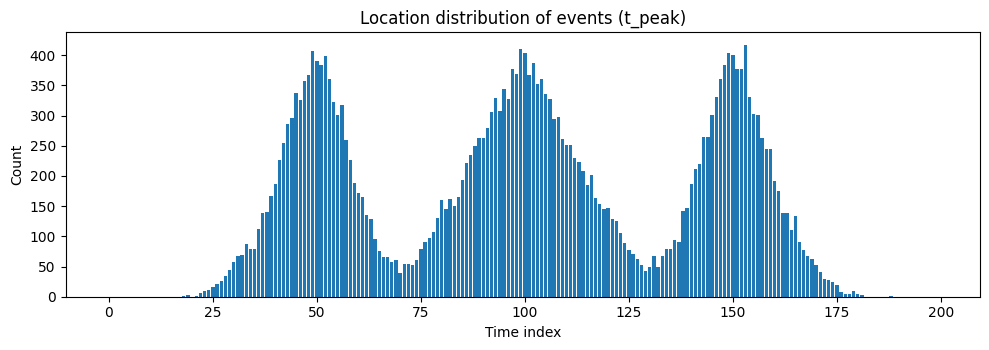

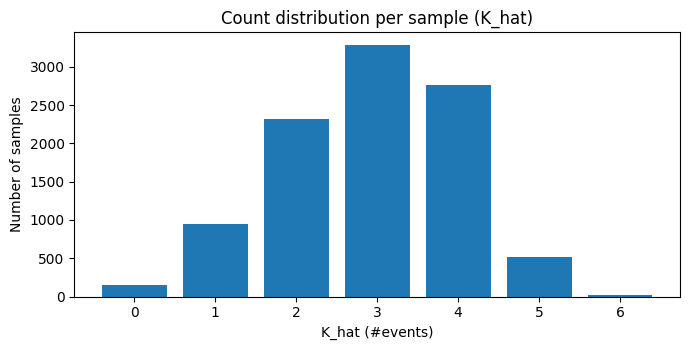

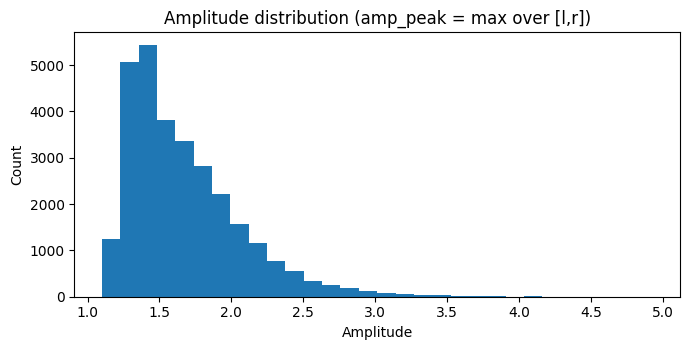

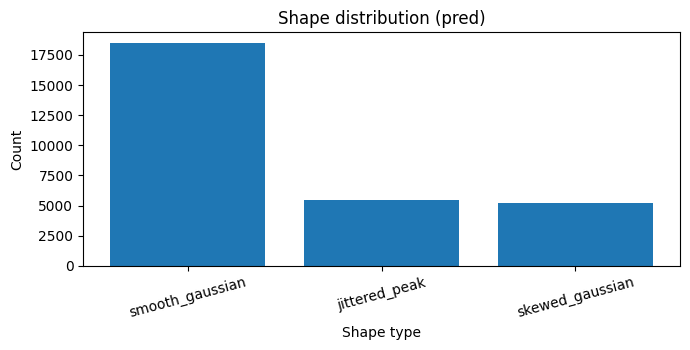

In [8]:
out = plot_and_summarize_4_distributions_v2(
    X, events,
    L=200,
    shape_names=comps.get("shape_names", None),
    bins_amp=30,
    thr=1.0,
)

In [9]:
import numpy as np

def print_gt_shape_and_K(comps, shape_names=None):
    if shape_names is None:
        shape_names = comps.get("shape_names", {0:"shape0", 1:"shape1", 2:"shape2"})

    K = np.asarray(comps["K"], dtype=np.int32)          # (N,)
    S = np.asarray(comps["S"], dtype=np.int32)          # (N, K_n) padded with -1
    N, K_n = S.shape

    # mask out padding
    mask = (np.arange(K_n)[None, :] < K[:, None])       # (N, K_n) bool
    S_valid = S[mask]                                   # (sum(K),)

    # ---- GT shape distribution ----
    n_shapes = int(max(3, (S_valid.max() + 1) if S_valid.size > 0 else 3))
    gt_sc = np.bincount(S_valid.clip(min=0), minlength=n_shapes) if S_valid.size > 0 else np.zeros(n_shapes, dtype=np.int64)
    total_events = int(S_valid.size)

    print("===== Ground Truth (from comps) =====")
    print(f"N_samples = {N}")
    print(f"GT total events = {total_events}")
    print("== GT Shape distribution ==")
    for s in range(n_shapes):
        name = shape_names.get(s, f"shape{s}")
        c = int(gt_sc[s])
        r = (c / total_events) if total_events > 0 else 0.0
        print(f"  shape={s} ({name}): count={c}, ratio={r:.4f}")

    # ---- GT K distribution ----
    K_max = int(K.max()) if N > 0 else 0
    K_counts = np.bincount(K, minlength=K_max + 1)
    print("\n== GT K distribution ==")
    print(f"mean={K.mean():.4f}, std={K.std():.4f}, min={int(K.min())}, max={int(K.max())}")
    for k, c in enumerate(K_counts):
        print(f"  K_true={k}: count={int(c)}, ratio={float(c)/float(N):.4f}")
    print("=====================================")

def print_pred_shape_from_events(events, shape_names=None):
    # events: list length N, each is list of dicts with key "shape"
    shapes = []
    for ei in events:
        for e in ei:
            shapes.append(int(e["shape"]))
    shapes = np.asarray(shapes, dtype=np.int32)

    total = int(shapes.size)
    n_shapes = int(max(3, (shapes.max() + 1) if total > 0 else 3))
    sc = np.bincount(shapes, minlength=n_shapes) if total > 0 else np.zeros(n_shapes, dtype=np.int64)

    if shape_names is None:
        shape_names = {0:"shape0", 1:"shape1", 2:"shape2"}

    print("===== Pred Shape (from events) =====")
    print(f"Pred total events = {total}")
    for s in range(n_shapes):
        name = shape_names.get(s, f"shape{s}")
        c = int(sc[s])
        r = (c / total) if total > 0 else 0.0
        print(f"  shape={s} ({name}): count={c}, ratio={r:.4f}")
    print("===================================")

# 用法：
print_gt_shape_and_K(comps, shape_names=comps.get("shape_names"))
print_pred_shape_from_events(events, shape_names=comps.get("shape_names"))


===== Ground Truth (from comps) =====
N_samples = 10000
GT total events = 30084
== GT Shape distribution ==
  shape=0 (smooth_gaussian): count=18036, ratio=0.5995
  shape=1 (jittered_peak): count=6112, ratio=0.2032
  shape=2 (skewed_gaussian): count=5936, ratio=0.1973

== GT K distribution ==
mean=3.0084, std=1.2278, min=0, max=6
  K_true=0: count=149, ratio=0.0149
  K_true=1: count=948, ratio=0.0948
  K_true=2: count=2324, ratio=0.2324
  K_true=3: count=3113, ratio=0.3113
  K_true=4: count=2330, ratio=0.2330
  K_true=5: count=987, ratio=0.0987
  K_true=6: count=149, ratio=0.0149
===== Pred Shape (from events) =====
Pred total events = 29170
  shape=0 (smooth_gaussian): count=18455, ratio=0.6327
  shape=1 (jittered_peak): count=5484, ratio=0.1880
  shape=2 (skewed_gaussian): count=5231, ratio=0.1793


In [10]:
X1 = X.reshape(-1,1)
L = 200
N = 10000
np.save(f"top_example_seq_{L}_sample_{N}.npy", X1)

In [12]:
X1.shape

(2000000, 1)